# Airfoil experiments
All data is available in the repository

In [1]:
import sys
sys.path.append('../python')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from machine_learning import *
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


# Setup

In [2]:
qmc_points = np.loadtxt('../sobol_6_8000.txt')
qmc_points = qmc_points[1:].reshape((8000,6))

large_qmc_points = np.loadtxt('../sobol_6_131072.txt')
all_points = qmc_points.copy()
forces = np.array(np.loadtxt('../force_6_params.dat'))


N = min(qmc_points.shape[0], forces.shape[0])
qmc_points = qmc_points[:N,:]
forces  = forces[:N,:]


input_size=6
train_size=128
validation_size=128

epochs = 500000


airfoils_network = [12, 12, 10, 12, 10, 12, 10, 10, 12,1]


# One network per variable


Training took 420.1257243156433 seconds


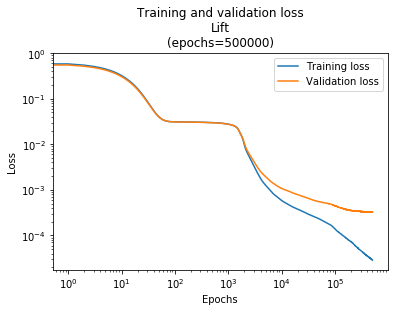

In [ ]:
force_names=['Lift', 'Drag']
batch_sizes=[train_size]
train_sizes = [16, 32, train_size]

optimizers = {"SGD": keras.optimizers.SGD,
             "Adam": keras.optimizers.Adam}

losses = ["mean_squared_error", "mean_absolute_error"]

for optimizer in optimizers.keys():
    for loss in losses:
        display(HTML("<h1>{} with {}</h1>".format(optimizer, loss)))

        for batch_size in batch_sizes:
            tables = Tables.make_default()
            
            for (n, f) in enumerate(force_names):
                seed_random_number(random_seed)
                network_information = NetworkInformation(optimizer=optimizers[optimizer], epochs=epochs, 
                                                         network=airfoils_network, train_size=train_size,
                                                         validation_size=validation_size,
                                                        loss=loss, 
                                                        large_integration_points=large_qmc_points)
                
                output_information = OutputInformation(tables=tables, title=force_names[n],
                                                      short_title=force_names[n])
                showAndSave.prefix='airfoil_%s_%s_%s_ts_%d_bs_%d' %(optimizer, loss, f,batch_size, train_size)
                get_network_and_postprocess(qmc_points, forces[:,n+1], network_information = network_information,
                    output_information = output_information)
            
            showAndSave.prefix='airfoil_%s_%s_all_ts_%d_bs_%d' %(optimizer, loss, batch_size, train_size)
            tables.write_tables()
  